<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
## <font color='blue'>Cloud Computing Data Science</font>
## <font color='blue'>Projeto 5</font>
### <font color='blue'>Modelo de Machine Learning com LightGBM Para Portfólio de Investimentos com SageMaker</font>

## Definindo Pacotes, Sessão e Role

In [1]:
# Filtrando warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Imports
import logging
import sagemaker, boto3, json
from sagemaker import get_execution_role
from sagemaker import image_uris, model_uris, script_uris
from sagemaker import hyperparameters
from sagemaker.tuner import ContinuousParameter, IntegerParameter, HyperparameterTuner
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:
# Define a role de execução, a região e cria a sessão SageMaker
aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

In [4]:
# Configura um logger em Python para facilitar o registro de mensagens de log 
# em diferentes níveis (como DEBUG, INFO, WARNING, ERROR, e CRITICAL)
logger = logging.getLogger('__name__')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

In [5]:
# Versões dos pacotes principais
logger.info(f'Versão do SageMaker: {sagemaker.__version__}')
logger.info(f'Versão do Boto3: {boto3.__version__}')

Versão do SageMaker: 2.227.0
Versão do Boto3: 1.34.162


## Definindo o Modelo LightGBM e a Instância de Treino

Veja o videobook do Capítulo 10 com a definição completa do LightGBM.

https://lightgbm.readthedocs.io/en/latest/

In [6]:
# Definindo o modelo (instância do modelo pré-treinada pela AWS)
train_model_id, train_model_version, train_scope = "lightgbm-classification-model", "2.1.6", "training"

https://docs.aws.amazon.com/sagemaker/latest/dg/notebooks-available-instance-types.html

In [7]:
# Definindo a instância de treino
# ESTA INSTÂNCIA NÃO É GRATUITA
training_instance_type = "ml.m5.xlarge"

## Definindo a URI da Imagem Docker

https://sagemaker.readthedocs.io/en/stable/api/utility/image_uris.html

In [8]:
# Retrieve da docker image
train_image_uri = image_uris.retrieve(region = None,
                                      framework = None,
                                      model_id = train_model_id,
                                      model_version = train_model_version,
                                      image_scope = train_scope,
                                      instance_type = training_instance_type)

## Definindo o Script de Treino

In [9]:
# Retrieve do script de treino
train_source_uri = script_uris.retrieve(model_id = train_model_id, 
                                        model_version = train_model_version, 
                                        script_scope = train_scope)

In [10]:
# Retrieve do modelo pré-treinado
train_model_uri = model_uris.retrieve(model_id = train_model_id, 
                                      model_version = train_model_version, 
                                      model_scope = train_scope)

In [11]:
# Entrada (coloque os dados no bucket S3 como demonstrado nas aulas)
training_data_bucket = f"dsa-p5-890582101704"
training_data_prefix = "dados_treino/"

training_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}"

# Saída
output_bucket = f"dsa-p5-890582101704"
output_prefix = "dsa-projeto5-modelo"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

## Definindo os Hiperparâmetros

In [12]:
# Retrieve dos hiperparâmetros para o fine-tuning do modelo
hyperparameters = hyperparameters.retrieve_default(model_id = train_model_id, 
                                                   model_version = train_model_version)

In [13]:
# [Opcional] Substituir valores de hiperparâmetros por valores personalizados
hyperparameters["num_boost_round"] = "500"  

In [14]:
print(hyperparameters)

{'num_boost_round': '500', 'early_stopping_rounds': '30', 'metric': 'auto', 'learning_rate': '0.009', 'num_leaves': '67', 'feature_fraction': '0.74', 'bagging_fraction': '0.53', 'bagging_freq': '5', 'max_depth': '11', 'min_data_in_leaf': '26', 'max_delta_step': '0.0', 'lambda_l1': '0.0', 'lambda_l2': '0.0', 'boosting': 'gbdt', 'min_gain_to_split': '0.0', 'scale_pos_weight': '1.0', 'tree_learner': 'serial', 'feature_fraction_bynode': '1.0', 'is_unbalance': 'False', 'max_bin': '255', 'num_threads': '0', 'verbosity': '1', 'use_dask': 'False'}


In [15]:
# Range de hiperparâmetros para otimização durante o treino
# Veja a descrição no videobook do Capítulo 10 do curso.
if train_model_id == "lightgbm-classification-model":
    hyperparameter_ranges = {
        "learning_rate": ContinuousParameter(1e-4, 1, scaling_type = "Logarithmic"),
        "num_boost_round": IntegerParameter(2, 30),
        "early_stopping_rounds": IntegerParameter(2, 30),
        "num_leaves": IntegerParameter(10, 50),
        "feature_fraction": ContinuousParameter(0, 1),
        "bagging_fraction": ContinuousParameter(0, 1),
        "bagging_freq": IntegerParameter(1, 10),
        "max_depth": IntegerParameter(5, 30),
        "min_data_in_leaf": IntegerParameter(5, 50),
    }

## Criando Job e Estimador

In [16]:
# Define o nome do job de treino
training_job_name = name_from_base(f"dsa-p5-{train_model_id}-training")

In [17]:
# Cria o estimador
tabular_estimator = Estimator(role = aws_role,
                              image_uri = train_image_uri,
                              source_dir = train_source_uri,
                              model_uri = train_model_uri,
                              entry_point = "transfer_learning.py",
                              instance_count = 1,
                              instance_type = training_instance_type,
                              max_run = 360000,
                              hyperparameters = hyperparameters,
                              output_path = s3_output_location)

## Treinamento do Modelo

O AMT ("Automatic Model Tuning") no Amazon SageMaker refere-se ao recurso de Hyperparameter Tuning, que permite ajustar automaticamente os hiperparâmetros de um modelo de Machine Learning para alcançar o melhor desempenho possível.

Se use_amt for definido como True, o código utilizará o Hyperparameter Tuner para ajustar os hiperparâmetros do modelo, otimizando a métrica especificada (multi_logloss, no caso). Caso contrário, o modelo será treinado diretamente com os hiperparâmetros fornecidos, sem ajuste automático.

In [18]:
use_amt = True

In [19]:
%%time

if use_amt:
    tuner = HyperparameterTuner(tabular_estimator,
                                "multi_logloss",
                                hyperparameter_ranges,
                                [{"Name": "multi_logloss", "Regex": "multi_logloss: ([0-9\\.]+)"}],
                                max_jobs = 10,
                                max_parallel_jobs = 2,
                                objective_type = "Minimize",
                                base_tuning_job_name = training_job_name)

    tuner.fit({"training": training_dataset_s3_path}, logs = True)
else:
    # Inicia um job de treinamento do SageMaker passando o caminho s3 dos dados de treinamento
    tabular_estimator.fit(
        {"training": training_dataset_s3_path}, logs = True, job_name = training_job_name
    )

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.................................................................................!
CPU times: user 329 ms, sys: 42.4 ms, total: 371 ms
Wall time: 6min 58s


## Definindo a Instância de Inferência

In [20]:
# ESTA INSTÂNCIA NÃO É GRATUITA
inference_instance_type = "ml.m5.xlarge"

In [21]:
# Retrieve da URI do container docker de inferência
deploy_image_uri = image_uris.retrieve(region = None,
                                       framework = None,
                                       image_scope = "inference",
                                       model_id = train_model_id,
                                       model_version = train_model_version,
                                       instance_type = inference_instance_type)

## Definindo o Script de Inferência

In [22]:
# Retrieve do script de inferência
deploy_source_uri = script_uris.retrieve(model_id = train_model_id, 
                                         model_version = train_model_version, 
                                         script_scope = "inference")

In [23]:
# Define o nome do endpoint
endpoint_name = name_from_base(f"dsa-p5-model-{train_model_id}-")

In [24]:
# Usamos o estimador da etapa anterior para implantar em um endpoint do SageMaker
predictor = (tuner if use_amt else tabular_estimator).deploy(initial_instance_count = 1,
                                                             instance_type = inference_instance_type,
                                                             entry_point = "inference.py",
                                                             image_uri = deploy_image_uri,
                                                             source_dir = deploy_source_uri,
                                                             endpoint_name = endpoint_name)


2024-12-11 01:13:25 Starting - Found matching resource for reuse
2024-12-11 01:13:25 Downloading - Downloading the training image
2024-12-11 01:13:25 Training - Training image download completed. Training in progress.
2024-12-11 01:13:25 Uploading - Uploading generated training model
2024-12-11 01:13:25 Completed - Resource retained for reuse
-----!

## Carregando os Dados de Teste

In [25]:
# Variáveis de controle
dsa_assets_bucket = f"dsa-p5-890582101704"
test_data_prefix = "dados_teste"
test_data_file_name = "data.csv"

In [26]:
# Faz o download dos dados de teste
boto3.client("s3").download_file(dsa_assets_bucket, f"{test_data_prefix}/{test_data_file_name}", test_data_file_name)

In [27]:
# Vamos visualizar os dados

# Variáveis para definir cor e formato do texto
newline, bold, unbold = "\n", "\033[1m", "\033[0m"

# Imports
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Carrega os dados
test_data = pd.read_csv(f"{test_data_file_name}", header=None)
test_data.columns = ["Target"] + [f"Feature_{i}" for i in range(1, test_data.shape[1])]

# Shape
num_examples, num_columns = test_data.shape
print(f"{bold}O conjunto de dados de teste contém {num_examples} exemplos e {num_columns} colunas.{unbold}\n")

# Prepara os dados reais para as previsões com o endpoint do modelo
ground_truth_label, features = test_data.iloc[:, :1], test_data.iloc[:, 1:]

print(f"{bold}As primeiras 5 observações dos dados: {unbold} \n")
test_data.head(5)

O conjunto de dados de teste contém 10000 exemplos e 785 colunas.

As primeiras 5 observações dos dados:  



,Target,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_775,Feature_776,Feature_777,Feature_778,Feature_779,Feature_780,Feature_781,Feature_782,Feature_783,Feature_784
0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# Variável para o tipo de conteúdo
content_type = "text/csv"

## Extraindo Previsões com o Endpoint

In [29]:
# Função para usar o endpoint
def dsa_query_endpoint(encoded_tabular_data):

    # Cria o cliente
    client = boto3.client("runtime.sagemaker")

    # Invoca o endpoint
    response = client.invoke_endpoint(EndpointName = endpoint_name, 
                                      ContentType = content_type, 
                                      Body = encoded_tabular_data)
    
    return response

In [30]:
# Função para formatar o resultado do endpoint
def dsa_parse_response(query_response):

    # Extrai as previsões do modelo
    model_predictions = json.loads(query_response["Body"].read())

    # Extrai as previsões de probabilidade
    predicted_probabilities = model_predictions["probabilities"]
    
    return np.array(predicted_probabilities)

In [31]:
# Divide os dados de teste em lotes menores para consultar o endpoint devido ao grande tamanho dos dados de teste.
batch_size = 1500
predict_prob = []

In [32]:
# Loop para extrair as previsões
for i in np.arange(0, num_examples, step = batch_size):

    # Extrai as previsões
    query_response_batch = dsa_query_endpoint(
        features.iloc[i : (i + batch_size), :].to_csv(header = False, index = False).encode("utf-8"))

    # Previsão de probabilidade por batch
    predict_prob_batch = dsa_parse_response(query_response_batch) 

    # Armazena as previsões
    predict_prob.append(predict_prob_batch)

In [33]:
# Concatena as previsões
predict_prob = np.concatenate(predict_prob, axis = 0)

In [34]:
# O label previsto é aquele com maior probabilidade
predict_label = np.argmax(predict_prob, axis = 1)

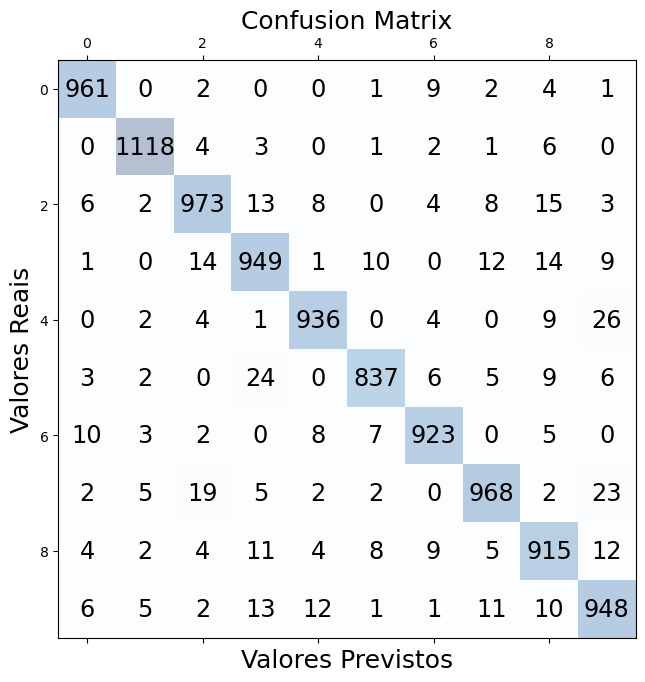

In [35]:
# Visualiza os resultados das previsões plotando a matriz de confusão
conf_matrix = confusion_matrix(y_true = ground_truth_label.values, y_pred = predict_label)
fig, ax = plt.subplots(figsize = (7.5, 7.5))
ax.matshow(conf_matrix, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x = j, 
                y = i, 
                s = conf_matrix[i, j], 
                va = "center", 
                ha = "center", 
                size = "xx-large")

plt.xlabel("Valores Previstos", fontsize = 18)
plt.ylabel("Valores Reais", fontsize = 18)
plt.title("Confusion Matrix", fontsize = 18)
plt.show()

## Avaliando as Previsões

In [36]:
# Calcula as métricas
eval_accuracy = accuracy_score(ground_truth_label.values, predict_label)
eval_f1_macro = f1_score(ground_truth_label.values, predict_label, average = "macro")
eval_f1_micro = f1_score(ground_truth_label.values, predict_label, average = "micro")

print(
    f"{bold}Avaliação dos Resultados nos Dados de Teste{unbold}:{newline}"
    f"{bold}{accuracy_score.__name__}{unbold}: {eval_accuracy}{newline}"
    f"{bold}F1 Macro{unbold}: {eval_f1_macro}{newline}"
    f"{bold}F1 Micro{unbold}: {eval_f1_micro}{newline}"
)

Avaliação dos Resultados nos Dados de Teste:
accuracy_score: 0.9528
F1 Macro: 0.9525089343905601
F1 Micro: 0.9528



Podemos responder à diretoria com segurança: Sim, com os dados históricos fornecidos podemos construir um modelo com boa capacidade preditiva.

In [37]:
# Deleta o modelo e o endpoint (se não forem mais usados)
predictor.delete_model()
predictor.delete_endpoint()

Lembre-se de limpar o bucket S3.

# Fim